# Simple fitness landscape

(c) 2019 Manuel Razo. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT). 

---

In [1]:
import os

# Our numerical workhorses
import numpy as np
import scipy
import pandas as pd

# Import matplotlib stuff for plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib

# Seaborn, useful for graphics
import seaborn as sns

# Import the project utils
import sys
sys.path.insert(0, '../../')
import infofit_utils as utils

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline (only use with static plots (non-Bokeh))
%config InlineBackend.figure_format = 'svg'

figdir = '../../fig/simple_fitness_landscape/'
tmpdir = '../../tmp/'

In [2]:
# Set PBoC plotting format
utils.viz.set_plotting_style()

## Implementing a simple fitness landscape

On an excellent and intriguing paper, [Dekel and Alon](https://www.nature.com/articles/nature03842) measured the cost and benefit function of producing *LacZ* protein. In this paper they measure the cost and benefit of producing the enzyme, finding that non-linearities in this cost-benefit function predicted an optimal expression expression level. With this they can create a fitness lanscape as a function of the lactose concentration in the environment and the enzyme expression level. This fitness landscape was then used by [Taylor, Tishby and Bialek](https://arxiv.org/abs/0712.4382) while analyzing the connection beteen information as defined by Shannon's information theory and biological fitness.

### Fitness cost of producing protein

Dekel and Alon propose two models for the cost function. The first model $\eta_1$ assumes that the cost has a quadratic form, i.e.
\begin{equation}
    \eta_1(p) \equiv \eta_0 p + \eta_0' p^2,
\end{equation}
where $\eta_0$ and $\eta_0'$ are phenomenological parameters for this model, and $p$ is the LacZ protein expression level.

For the second model they assume that given a resource $c$, for example lactose, the cellular growth rate $\mu$ can be modeled by the monod equation
\begin{equation}
    \mu = \mu_\max \frac{c}{K_s + c},
\end{equation}
where $\mu_\max$ is the maximum growth rate and $K_s$ is the "half growth rate" phenomenological constant.

If we assume that the production of a single enzyme decreases the resource $c$ by a factor $\varepsilon$, then the growth rate $\mu$ as a function of the enzyme concentration is given by
\begin{equation}
    \mu(p) = \mu_\max \frac{c - \varepsilon p}{K_s + c - \varepsilon p}.
\end{equation}

This gives a cost function $\eta_2$ of the form
\begin{equation}
    \eta_2(p) = \frac{\mu(0) - \mu(p)}{\mu(p)} = \frac{\eta_o p}{1 - \frac{p}{M}},
\end{equation}
where $\eta_o = \frac{\varepsilon K_s}{C (K_s + C)}$ and $M = \frac{K_s + C}{\varepsilon}$.

This cost function reaches its maximum value of 1 when $ \varepsilon p = C $

The authors give the values of these parameters with respect to the expression level of the wildtype strain when fully induced with saturating IPTG $p_{wt}$. These values are
1. $\eta_o \cdot p_{wt} = 0.02 \pm 0.003$
2. $M = (1.8 \pm 0.3) p_{wt}$

With these values in hand we can plot the cost function as a function of this relative expression level.
Let's first define a function to compute this cost.

In [3]:
def cost_func(p_rel, eta_o=0.02, M=1.8):
    '''
    Returns the relative growth rate cost of producing LacZ protein according to
    Dekel and Alon's model:
        eta_2 = eta_o * p_rel / (1 - p_rel / M)
    
    Parameter
    ---------
    p_rel : array-like.
        Relative expression with respect to the wild type expression when
        fully induced with IPTG
    eta_o : float.
        Parameter of the cost function
    M : float.
        Parameter of the cost function
    
    Returns
    -------
    eta_2 : array-like
        relative reduction in growth rate with respect to wild type when not
        expressing the enzyme.
    '''
    p_rel = np.array(p_rel)
    return eta_o * p_rel / (1 - p_rel / M)

Now let's plot the resulting cost function

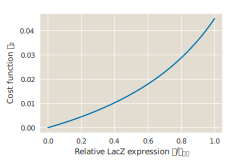

In [4]:
# Define range of relative expressions with respect to the fully induced WT
p_rel = np.linspace(0, 1, 200)

# Plot cost function
plt.plot(p_rel, cost_func(p_rel))

# Label axis
plt.xlabel(r'Relative LacZ expression $p / p_{wt}$')
plt.ylabel(r'Cost function $\eta_2$')

plt.tight_layout()

### Fitness benefit of producing the enzyme

The benefit of producing the enzyme in the presence of lactose is capture by a monod-like expression. What this means is that just as we did to derive the cost function, we assume that the growth rate $\mu$ is given by
\begin{equation}
    \mu = \mu_\max \frac{c}{K_s + c},
\end{equation}

### Building a fitness landscape

Puting the cost and benefit funcitons together together we obtain an expression for the relative growth rate $r$
\begin{equation}
    r(C, p) = \delta \cdot p \frac{C}{K_s + C} - \frac{\eta_o p}{1 - \frac{p}{M}},
\end{equation}
where $ \delta $ is the fitness benefit per substrate cleaved per enzyme and $ K_s $ is the Monod constant that gives half the maximum growth rate possible.

The values for these constants reported by the authors are
1. $\delta$ = 0.17.
2. $K_s$ = 0.4 mM.

The maximum for this fitness funciton can be obtained by computing $\frac{dr}{dp} = 0$.
This results in the optimum protein expression level $ p^* $ given by
\begin{equation}
    p^* = M \left( 1 - \sqrt{\frac{\eta}{\delta} \frac{C + K_s}{C}} \right).
\end{equation}

Dekel and Alon specify that $p^* = 0$ for concentrations lower than
\begin{equation}
    C = K_s \left( \frac{\delta}{\eta} - 1 \right)^{-1} \approx 0.057 mM,
\end{equation}
since the cost exceeds the benefit.

With this we can compute and plot the fitness landscape as a function of the relative expression level and the substrate concentration. Let's define the necessary functions to compute this fitness landscape.

In [5]:
def benefit_func(p_rel, C_array, delta=0.17, Ks=0.4):
    '''
    Returns the relative growth rate benefit of producing LacZ protein 
    according to Dekel and Alon's model:
        r = delta * p_rel * C / (Ks + C)
    
    Parameter
    ---------
    p_rel : array-like.
        Relative expression with respect to the wild type expression when
        fully induced with IPTG.
    C_array : array-like.
        Substrate concentration.
    delta : float.
        growth benefit per substrate cleaved per enzyme.
    Ks : float.
        Monod constant for half maximum growth rate.
    
    Returns
    -------
    r : array-like
        relative increase in growth rate with respect to wild type when not
        expressing the enzyme.
    '''
    p_rel = np.array(p_rel)
    return delta * p_rel * C_array / (Ks + C_array)

def fitness(p_rel, C_array, delta=0.17, Ks=0.4, eta_o=0.02, M=1.8,
           logC=False):
    '''
    Returns the relative fitness according to Dekel and Alon's model.
    
    Parameter
    ---------
    p_rel : array-like.
        Relative expression with respect to the wild type expression when
        fully induced with IPTG.
    C_array : array-like.
        Substrate concentration. If logC==True this is defined as log10(C)
    delta : float.
        growth benefit per substrate cleaved per enzyme.
    Ks : float.
        Monod constant for half maximum growth rate.
    eta_o : float.
        Parameter of the cost function
    M : float.
        Parameter of the cost function
    logC : Bool.
        boolean indicating if the concentration is given in log scale
    
    Returns
    -------
    fitness : array-like
        relative fitness with respect to wild type when not
        expressing the enzyme.
    '''
    p_rel = np.array(p_rel)
    C_array = np.array(C_array)
    if logC:
        C_array = 10**C_array
    # Compute benefit - cost
    return benefit_func(p_rel, C_array, delta, Ks) - cost_func(p_rel, eta_o, M)

def p_opt(C_array, delta=0.17, Ks=0.4, eta_o=0.02, M=1.8, logC=False):
    '''
    Returns the optimal protein expression level p* as a function of
    substrate concentration.
    
    Parameters
    ----------
    C_array : array-like.
        Substrate concentration.
    delta : float.
        growth benefit per substrate cleaved per enzyme.
    Ks : float.
        Monod constant for half maximum growth rate.
    eta_o : float.
        Parameter of the cost function
    M : float.
        Parameter of the cost function
    logC : Bool.
        boolean indicating if the concentration is given in log scale
        
    Returns
    -------
    p* the optimal expression level for a given concentration.
    '''
    C_array = np.array(C_array)
    if logC:
        C_array = 10**C_array
    
    # Dekel and Alon specify that concentrations lower than a lower 
    # threshold should be zero. Then let's build that array
    thresh = Ks * (delta / eta_o - 1)**-1
    
    popt = np.zeros_like(C_array)
    popt[C_array > thresh] = M * (1 - np.sqrt(eta_o / delta * \
        (C_array[C_array > thresh] + Ks) / C_array[C_array > thresh]))
    
    return popt

To test these function let's reproduce Dekel and Alon's plots for different environemntal lactose concentrations.

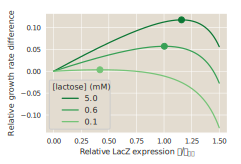

In [6]:
# Define the relative expression levels and the lactose concentrations
p_rel = np.linspace(0, 1.5, 200)
C_array = [5.0, 0.6, 0.1]

# Compute the relative fitness and the optimal expression level
r_mat = np.zeros([len(C_array), len(p_rel)])
popt = np.zeros(len(C_array))
r_max = np.zeros(len(C_array))

# Compute the different curves
for i, c in enumerate(C_array):
    r_mat[i, :] = fitness(p_rel, c)
    popt[i] = p_opt(c)
    r_max[i] = fitness(popt[i], c)

# Define color palette
colors = sns.color_palette('Greens_r', n_colors=len(C_array) + 2)
# Plot curves along with optimal expression level
for i, r in enumerate(r_mat):
    plt.plot(p_rel, r, label=r'{0:0.1f}'.format(C_array[i]), 
             color=colors[i])
    plt.scatter(popt[i], r_max[i], color=colors[i])

# Add legend
plt.legend(loc=0, title=r'[lactose] (mM)')

# Label axis
plt.xlabel(r'Relative LacZ expression $p / p_{wt}$')
plt.ylabel(r'Relative growth rate difference')

plt.tight_layout()

Great! Now we have the functions to define the whole fitness landscape. Let's just go and plot it.

## Plotting the fitness landscape and the optimal expression level

Having reproduced the cost-benefit function we can now extend the range and plot the entire fitness landscape by defining a grid of expession values and a grid of lactose concentrations.

In [7]:
# Define the sugar concentrations grid
c_min = 0
c_max = 1
C_array = np.linspace(c_min, c_max, 500)

# Define the relative expressions to evaluate
p_rel_min = 0
p_rel_max = 1.5
p_rel = np.linspace(p_rel_min, p_rel_max, 501)

# Generate grid to evaluate the fitness landscape
x_mat, y_mat = np.meshgrid(C_array, p_rel)

# Initialize matrix to save growth rate
fitness_landscape = np.empty(np.shape(x_mat))

# Compute the fitness for every lactose concentration and relative expression
for i, x in enumerate(x_mat):
    fitness_landscape[i, :] = fitness(y_mat[i, :], x)
    
# Compute the optimal expression level for each concentration in S_array
p_rel_opt = p_opt(C_array)

Let's now plot the fitness lanscape.

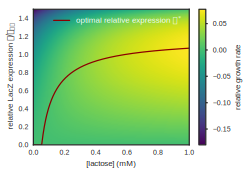

In [8]:
with sns.axes_style('white'):
    fig = plt.figure()
    ax = plt.subplot(111)
    cax = ax.matshow(fitness_landscape, cmap=cm.viridis,
                    origin='lower', extent=(c_min, c_max, p_rel_min, p_rel_max),
                    aspect='auto')
    ax.plot(C_array, p_rel_opt, label=r'optimal relative expression $p^*$',
           color='darkred')
    
    # Set plot limits
    ax.set_xlim([c_min, c_max])
    ax.set_ylim([p_rel_min, p_rel_max])
    
    # Add axis labels
    ax.set_xlabel(r'[lactose] (mM)')
    ax.set_ylabel(r'relative LacZ expression $p / p_{wt}$')
    
    # Add legend
    leg = ax.legend(loc=0, frameon=False)
    # Changing the color of the legend text
    for text in leg.get_texts():
        text.set_color("white")
    # Change default position of axis ticks
    ax.get_xaxis().set_ticks_position('bottom')
    
    # Set the ticks in both axis
    start, end = ax.get_xlim()
    ax.xaxis.set_ticks(np.arange(start, end + 0.1, 0.2))
    
    start, end = ax.get_ylim()
    ax.yaxis.set_ticks(np.arange(start, end + 0.1, 0.2))
    
    # Remove tick lines but still show labels
    ax.tick_params(axis='both', which='both',length=0, pad=5)
    
    # Add color-bar
    cbar = fig.colorbar(cax)
    cbar.ax.set_ylabel(r'relative growth rate')
    cbar.ax.tick_params(axis='both', which='both',length=2, pad=5)
    
# plt.tight_layout()

Eureka! We now have our fitness landscape.

### Plotting absolute growth rate.

To convert it to an "absolute" fitness measurement we need to convert the relative growth rate measurements to absolute growth rate in $\text{hr}^{-1}$. For this we find in the SI of the Dekel and Alon paper that the average reference growth rate was $1.15 \pm 0.015 \; \text{hr}^{-1}$. This means that if $r(c,p)$ is the **relative growth rate** as a function of the gene expression level $p$ and the substrate concentration $c$, then $f(c,p)$ is the **absolute growth rate** given by
\begin{equation}
f(c, p) = 1.15 \cdot (1 + r(c, p)) \; \text{hr}^{-1}.
\end{equation}

Let's define a function to compute this.

In [9]:
def abs_fitness(p_rel, C_array, delta=0.17, 
                Ks=0.4, eta_o=0.02, M=1.8,
                mu=1.15, logC=False):
    '''
    Returns the absolute fitness according to Dekel and Alon's model.
    
    Parameter
    ---------
    p_rel : array-like.
        Relative expression with respect to the wild type expression when
        fully induced with IPTG.
    C_array : array-like.
        Substrate concentration. If logC==True this is defined as log10(C)
    delta : float.
        growth benefit per substrate cleaved per enzyme.
    Ks : float.
        Monod constant for half maximum growth rate.
    eta_o : float.
        Parameter of the cost function
    M : float.
        Parameter of the cost function
    mu : float.
        Absolute growth rate of reference strain
    logC : Bool.
        boolean indicating if the concentration is given in log scale
    
    Returns
    -------
    fitnes : array-like
        absolute fitness of strain.
    '''
    p_rel = np.array(p_rel)
    C_array = np.array(C_array)
    if logC:
        C_array = 10**C_array
    # Compute benefit - cost
    rel_fit = benefit_func(p_rel, C_array, delta, Ks) -\
              cost_func(p_rel, eta_o, M)
    
    return mu * (1 + rel_fit)

Let's reproduce the plot above using this absolute growth rate.

In [10]:
# Define the sugar concentrations grid
c_min = 0
c_max = 1
C_array = np.linspace(c_min, c_max, 500)

# Define the relative expressions to evaluate
p_rel_min = 0
p_rel_max = 1.5
p_rel = np.linspace(p_rel_min, p_rel_max, 500)

# Generate grid to evaluate the fitness landscape
x_mat, y_mat = np.meshgrid(C_array, p_rel)

# Initialize matrix to save growth rate
fitness_landscape = np.empty(np.shape(x_mat))

# Compute the fitness for every lactose concentration and relative expression
for i, x in enumerate(x_mat):
    fitness_landscape[i, :] = abs_fitness(y_mat[i, :], x)
    
# Compute the optimal expression level for each concentration in S_array
p_rel_opt = p_opt(C_array)

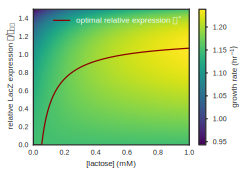

In [11]:
with sns.axes_style('white'):
    fig = plt.figure()
    ax = plt.subplot(111)
    cax = ax.matshow(fitness_landscape, cmap=cm.viridis,
                    origin='lower', extent=(c_min, c_max, p_rel_min, p_rel_max),
                    aspect='auto')
    ax.plot(C_array, p_rel_opt, label=r'optimal relative expression $p^*$',
           color='darkred')
    
    # Set plot limits
    ax.set_xlim([c_min, c_max])
    ax.set_ylim([p_rel_min, p_rel_max])
    
    # Add axis labels
    ax.set_xlabel(r'[lactose] (mM)')
    ax.set_ylabel(r'relative LacZ expression $p / p_{wt}$')
    
    # Add legend
    leg = ax.legend(loc=0, frameon=False)
    # Changing the color of the legend text
    for text in leg.get_texts():
        text.set_color("white")
    # Change default position of axis ticks
    ax.get_xaxis().set_ticks_position('bottom')
    
    # Set the ticks in both axis
    start, end = ax.get_xlim()
    ax.xaxis.set_ticks(np.arange(start, end + 0.1, 0.2))
    
    start, end = ax.get_ylim()
    ax.yaxis.set_ticks(np.arange(start, end + 0.1, 0.2))
    
    # Remove tick lines but still show labels
    ax.tick_params(axis='both', which='both',length=0, pad=5)
    
    # Add color-bar
    cbar = fig.colorbar(cax)
    cbar.ax.set_ylabel(r'growth rate (hr$^{-1})$')
    cbar.ax.tick_params(axis='both', which='both',length=2, pad=5)
    
# plt.tight_layout()

### Plotting the fitness landscape in log-scale

Given that we usually plot the $x$ axis of our induction curves on a log scale it would be useful to transform this axis of our fintess landscape into that scale.

Let's reproduce the plot above in log scale.

In [27]:
# Define the sugar concentrations and the relative expressions to evaluate
c_min_log = -1.5 # The minimum concentration at which there's a benefit
c_max_log = 0
C_array_log = np.logspace(c_min_log, c_max_log, 50)

# Define the the relative expressions to evaluate
p_rel_min_log = 0
p_rel_max_log = 1.4
p_rel_log = np.linspace(p_rel_min_log, p_rel_max_log, 51)

# Generate grid
x_mat_log, y_mat_log = np.meshgrid(C_array_log, p_rel_log)

# Initialize matrix to save growth rate
fitness_landscape_log = np.empty(np.shape(x_mat_log))

# Compute the fitness for every lactose concentration and relative expression
for i, x in enumerate(x_mat_log):
    fitness_landscape_log[i, :] = abs_fitness(y_mat_log[i, :], x)
    
# Compute the optimal expression level for each concentration in C_array
p_rel_opt_log = p_opt(C_array_log)

Having evaluated this, let's plot the fitness landscape.

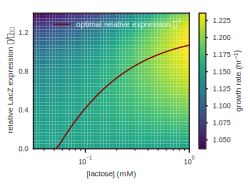

In [28]:
with sns.axes_style('white'):
    fig = plt.figure()
    ax = plt.subplot(111)
    cax = ax.pcolormesh(C_array_log, p_rel_log,
                        fitness_landscape_log[:-1, :-1],
                        cmap=cm.viridis)
    ax.plot(C_array_log, p_rel_opt_log, 
            label=r'optimal relative expression $p^*$',
            color='darkred')
    
    # Set log scale for x axis
    ax.set_xscale('log')
    
    # Set x axis ticks
    ax.tick_params(axis='x', which='minor', length=2, pad=5)
    ax.tick_params(axis='x', which='major', length=4, pad=5)
    
    # Set y axis ticks
    ax.yaxis.set_major_locator(matplotlib.ticker.MaxNLocator(4))
    
    # Set axis labels
    ax.set_xlabel(r'[lactose] (mM)')
    ax.set_ylabel(r'relative LacZ expression $p / p_{wt}$')
    
    # Add legend
    leg = ax.legend(loc=0, frameon=False)
    # Changing the color of the legend text
    for text in leg.get_texts():
        text.set_color("white")
    # Change default position of axis ticks
    ax.get_xaxis().set_ticks_position('bottom')
    
    # Add color-bar
    cbar = fig.colorbar(cax)
    cbar.ax.set_ylabel(r'growth rate (hr$^{-1})$')
    cbar.ax.tick_params(axis='both', which='both',length=2, pad=5)

# Alternative fitness landscape

Given the limitations that Uri's lanscape has, such as having a saturating relative expression set by parameter $M$ that is giving issues with the following scripts, in this section we will discuss an alternative version.

In his book Bialek discusses an alternative fitness landscape whith the following assumptions:
1. The enzyme LacZ acts in a Michaelis-Menten way, i.e.
\begin{equation}
    V = V_\max g \frac{C_{free}}{K_C + C_{free}},
\end{equation}
where $V$ and $V_\max$ are the enzyme rates and the maximum enzyme rate (in molecules per second) respectively, $K_C$ is the Michaelis constant, $C_{free}$ is the substrate concentration in souluion and $g$ is the enzyme copy number.
 2. The total substrate concentration is the sum of the free in solution and bound to the enzyme, i.e.
 \begin{equation}
     C = C_{free} + \frac{1}{\Omega} g \frac{C_{free}}{K_C + C_{free}},
 \end{equation}
 where $\Omega$ is the cell volume used to convert the enzyme copy number into concentration units.
 
3. Finally if the growth rate is proportional to the metabolic rate minus a linear term that represents the cost of making the enzyme we would have that our growth function $r$ is given by
\begin{equation}
    r(g, C) = \alpha g \frac{C_{free}}{K_C + C_{free}} - \beta g,
\end{equation}
where $\alpha$ is the benefit in growth per enzyme cleaved and $\beta$ is the metabolic cost of producing an enzyme.

If we solves for $C_{free}$ on the second assumption we find that
\begin{equation}
    C_{free} = \frac{1}{2} \left[ - \left( K_C + \frac{g}{\Omega} - C \right) \pm \sqrt{\left( K_C + \frac{g}{\Omega} - C \right)^2 + 4 K_C} \right],
\end{equation}
So substituting this into our function $r$ gives us the growth as a function of the enzyme and substrate concentration.

## Useful Bio-numbers.

In order to obtain reasonable numbers for this function we can always visit the beautiful bio-numbers website and other sources. The useful numbers for our case are
1. $K_C$ = 0.4 mM. Dekel and Alon paper. This is properly the constant for the LacY pump rather than LacZ, but they claim this is the relevant number for the physiology.
2. Beta-galactosidase tetramers per induced cell = 10000 [BNID:102019](http://bionumbers.hms.harvard.edu/bionumber.aspx?&id=102019&ver=3&trm=beta%20galactosidase)
3. 1000 protein / mRNA. Cell biology by the numbers.
4. $\Omega \approx$ 1 femto liter. PBoC.